In [2]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.feature_selection import RFE, VarianceThreshold, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from functools import partial

### Preprocessing the Data for Machine Learning Models

1. **Data Encoding:**
   - Encode categorical variables into numerical representations using techniques like one-hot encoding or label encoding.

2. **Normalization and Scaling:**
   - Normalize or scale numerical features to ensure uniformity and improve model performance.
   - Techniques include Min-Max scaling or Standardization.

3. **Feature Selection Methods**
    - Techniques include: filter, wrapper, and embedded methods.

4. **Data Splitting:**
   - Split the dataset into training and testing sets for machine learning models.

In [3]:
# Read ML file
file_path = './data/vax_trials_ml_df.csv'
df_ml = pd.read_csv(file_path)

# Display the DataFrame
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,0.002222,2.404444
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,0.176471,5.882353
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,0.488112,2.400000
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,0.040936,1.590987
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,0.209581,5.086826


- Data encoding: 

    - phase
    - gender
    - agency_class
    - country


In [4]:
# Define mapping for phase categories to numerical values
phase_mapping = {
    'Early Phase 1': 1,
    'Phase 1': 2,
    'Phase 1/Phase 2': 3,
    'Phase 2': 4,
    'Phase 2/Phase 3': 5,
    'Phase 3': 6,
    'Phase 4': 7,
    'Not Applicable': 0
}

# Map the 'phase' column to numerical values
df_ml['phase_encoded'] = df_ml['phase'].map(phase_mapping)

# Display df
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq,phase_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,0.002222,2.404444,6
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,0.176471,5.882353,2
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,0.488112,2.400000,4
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,0.040936,1.590987,6
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,0.209581,5.086826,4


In [5]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'gender' column
df_ml['gender_encoded'] = le.fit_transform(df_ml['gender'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq,phase_encoded,gender_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,0.002222,2.404444,6,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,0.176471,5.882353,2,0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,0.488112,2.400000,4,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,0.040936,1.590987,6,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,0.209581,5.086826,4,0


In [6]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'agency_class' column
df_ml['agency_class_encoded'] = le.fit_transform(df_ml['agency_class'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,0.002222,2.404444,6,0,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,0.176471,5.882353,2,0,1
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,0.488112,2.400000,4,0,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,0.040936,1.590987,6,0,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,0.209581,5.086826,4,0,0


In [7]:
# Drop 'phase','gender', angency_class columns
df_ml = df_ml.drop(['phase', 'gender', 'agency_class'], axis=1)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,country,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,450.0,infectious diseases,12.0,saudi arabia,3.111111,17.500000,1.0,1082.0,0.002222,2.404444,6,0,0
1,NCT00623831,17.0,cancer,60.0,germany,11.764706,41.500000,3.0,100.0,0.176471,5.882353,2,0,1
2,NCT00434577,715.0,infectious diseases,7.0,multiple,1.818182,33.899366,349.0,1716.0,0.488112,2.400000,4,0,0
3,NCT00616421,2907.0,infectious diseases,13.0,multiple,3.611971,6.000000,119.0,4625.0,0.040936,1.590987,6,0,0
4,NCT04515147,668.0,infectious diseases,17.0,multiple,8.532934,41.500000,140.0,3398.0,0.209581,5.086826,4,0,0


In [8]:
# Encode the 'country' column
df_ml = BinaryEncoder(cols=['country']).fit(df_ml).transform(df_ml)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,country_0,country_1,country_2,country_3,country_4,country_5,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,450.0,infectious diseases,12.0,0,0,0,0,0,1,3.111111,17.500000,1.0,1082.0,0.002222,2.404444,6,0,0
1,NCT00623831,17.0,cancer,60.0,0,0,0,0,1,0,11.764706,41.500000,3.0,100.0,0.176471,5.882353,2,0,1
2,NCT00434577,715.0,infectious diseases,7.0,0,0,0,0,1,1,1.818182,33.899366,349.0,1716.0,0.488112,2.400000,4,0,0
3,NCT00616421,2907.0,infectious diseases,13.0,0,0,0,0,1,1,3.611971,6.000000,119.0,4625.0,0.040936,1.590987,6,0,0
4,NCT04515147,668.0,infectious diseases,17.0,0,0,0,0,1,1,8.532934,41.500000,140.0,3398.0,0.209581,5.086826,4,0,0


#### Feature selection methods

Filter methods

- Variance threshold: to remove any features that have little to no variation in their values.
- Pearson’s correlation: measuring the linear relationship between two numeric, continuous variables. Correlation between features, and correlation between features and target.
- F-statistic: correlation between features and target.
- Mutual information: measures the dependence between two variables and can be used to estimate how much a feature contributes to the prediction of the target variable.

In [9]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5',
                       'phase_encoded', 'gender_encoded', 'agency_class_encoded', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

In [10]:
# Variance threshold
selector = VarianceThreshold(threshold=0)  # 0 is default
print(selector.fit_transform(features))

[[4.50000000e+02 1.20000000e+01 1.75000000e+01 ... 1.08200000e+03
  2.22222222e-03 2.40444444e+00]
 [1.70000000e+01 6.00000000e+01 4.15000000e+01 ... 1.00000000e+02
  1.76470588e-01 5.88235294e+00]
 [7.15000000e+02 7.00000000e+00 3.38993661e+01 ... 1.71600000e+03
  4.88111888e-01 2.40000000e+00]
 ...
 [3.00000000e+02 7.00000000e+00 3.35000000e+01 ... 4.20000000e+01
  1.00000000e-02 1.40000000e-01]
 [1.44700000e+03 1.20000000e+01 1.70000000e+01 ... 5.69900000e+03
  6.42709053e-02 3.93849343e+00]
 [4.80000000e+01 3.00000000e+00 3.38993661e+01 ... 2.48000000e+02
  1.25000000e-01 5.16666667e+00]]


In [11]:
# Use indices to get the corresponding column names of selected features
num_cols = list(features.columns[selector.get_support(indices=True)])
print(num_cols)

['enrollment', 'actual_duration', 'mean_age_imp', 'AE_total_serious', 'AE_total_other', 'AE_serious_freq', 'AE_other_freq']


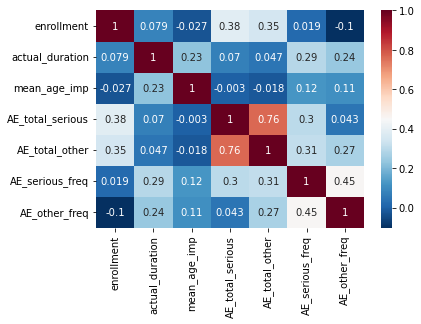

In [12]:
# Pearson’s correlation: 
# Correlation between features: drop highly correlated features to avoid duplicate information.

corr_matrix = features.corr(method='pearson') 

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [13]:
# Correlation between features and target

X_y = features.copy()
X_y['dropout_rate'] = target

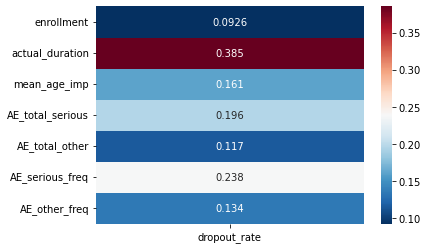

In [14]:
corr_matrix = X_y.corr()

# Isolate the column corresponding to 'dropout'
corr_target = corr_matrix[['dropout_rate']].drop(labels=['dropout_rate'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [15]:
# F-statistic: correlation between features and target
# The F-statistic will be larger (and p-value will be smaller) for predictors that are more highly correlated with the target variable
# First array: F-statistic
# Second array: p-value

print(f_regression(features, target))

(array([  8.60312975, 173.27695458,  26.48230427,  39.90765647,
        13.70198793,  59.74816589,  18.25417154]), array([3.43280514e-03, 1.34213986e-36, 3.20359371e-07, 4.00889249e-10,
       2.25984124e-04, 2.62919313e-14, 2.11851018e-05]))


In [16]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5','dropout_rate'], axis=1)
features.head()

,enrollment,actual_duration,mean_age_imp,AE_total_serious,AE_total_other,AE_serious_freq,AE_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,450.0,12.0,17.500000,1.0,1082.0,0.002222,2.404444,6,0,0
1,17.0,60.0,41.500000,3.0,100.0,0.176471,5.882353,2,0,1
2,715.0,7.0,33.899366,349.0,1716.0,0.488112,2.400000,4,0,0
3,2907.0,13.0,6.000000,119.0,4625.0,0.040936,1.590987,6,0,0
4,668.0,17.0,41.500000,140.0,3398.0,0.209581,5.086826,4,0,0


In [17]:
# Mutual information

# features
features = df_ml.drop(['nct_id', 'condition_name', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

print(mutual_info_regression(features, target, discrete_features=[7,8,9], random_state=68))

[0.20690065 0.18079146 0.         0.         0.         0.01335876
 0.03312612 0.02124729 0.09001127 0.11275745 0.07971436 0.14108076
 0.         0.02959393 0.03127311 0.03274056]


In [18]:
score_func = partial(mutual_info_regression, discrete_features=[7,8,9], random_state=68)

# Select top 5 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=5)

print(selection.fit_transform(features, target))

[[4.50000000e+02 1.20000000e+01 1.75000000e+01 1.00000000e+00
  2.22222222e-03]
 [1.70000000e+01 6.00000000e+01 4.15000000e+01 3.00000000e+00
  1.76470588e-01]
 [7.15000000e+02 7.00000000e+00 3.38993661e+01 3.49000000e+02
  4.88111888e-01]
 ...
 [3.00000000e+02 7.00000000e+00 3.35000000e+01 3.00000000e+00
  1.00000000e-02]
 [1.44700000e+03 1.20000000e+01 1.70000000e+01 9.30000000e+01
  6.42709053e-02]
 [4.80000000e+01 3.00000000e+00 3.38993661e+01 6.00000000e+00
  1.25000000e-01]]


In [19]:
X = features[features.columns[selection.get_support(indices=True)]]
print(X)

     enrollment  actual_duration  mean_age_imp  AE_total_serious  \
0         450.0             12.0     17.500000               1.0   
1          17.0             60.0     41.500000               3.0   
2         715.0              7.0     33.899366             349.0   
3        2907.0             13.0      6.000000             119.0   
4         668.0             17.0     41.500000             140.0   
..          ...              ...           ...               ...   
992       406.0             19.0     20.000000               0.0   
993        50.0             56.0     41.500000              38.0   
994       300.0              7.0     33.500000               3.0   
995      1447.0             12.0     17.000000              93.0   
996        48.0              3.0     33.899366               6.0   

     AE_serious_freq  
0           0.002222  
1           0.176471  
2           0.488112  
3           0.040936  
4           0.209581  
..               ...  
992         0.000000  

One-Hot Encoding:

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.
- disadvantage: it can lead to a high-dimensional feature space if there are many unique diseases, so it may not be efficient for large datasets.

In [20]:
# Create dummy variables for 'condition_name' 
df_ml = pd.get_dummies(df_ml, columns=['condition_name'], prefix=['condition'])
df_ml.head()

,nct_id,enrollment,actual_duration,country_0,country_1,country_2,country_3,country_4,country_5,dropout_rate,...,condition_cancer,condition_chronic diseases,condition_congenital disorders,condition_healthy,condition_heart diseases,condition_infectious diseases,condition_inflammatory diseases,condition_pregnancy,condition_respiratory disorders,condition_transplant
0,NCT00444951,450.0,12.0,0,0,0,0,0,1,3.111111,...,0,0,0,0,0,1,0,0,0,0
1,NCT00623831,17.0,60.0,0,0,0,0,1,0,11.764706,...,1,0,0,0,0,0,0,0,0,0
2,NCT00434577,715.0,7.0,0,0,0,0,1,1,1.818182,...,0,0,0,0,0,1,0,0,0,0
3,NCT00616421,2907.0,13.0,0,0,0,0,1,1,3.611971,...,0,0,0,0,0,1,0,0,0,0
4,NCT04515147,668.0,17.0,0,0,0,0,1,1,8.532934,...,0,0,0,0,0,1,0,0,0,0


#### Recursive Feature Elimination

In [21]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate'], axis=1)
y = df_ml['dropout_rate']

In [22]:
# Get feature names
features = x.columns

# Create a linear regression model
lm = LinearRegression()

# Standardize the data
x = pd.DataFrame(StandardScaler().fit_transform(x))

# Create a recursive feature elimination model
rfe = RFE(estimator=lm, n_features_to_select=6)

# Fit the recursive feature elimination model to x and y
rfe.fit(x, y)

# Print the model accuracy after doing recursive feature elimination
print(rfe.score(x, y))

# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

0.23650981513355185
['actual_duration', 'country_4', 'AE_total_serious', 'AE_serious_freq', 'condition_autoimmune diseases', 'condition_cancer']


In [23]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate'], axis=1)
y = df_ml['dropout_rate']

In [24]:
# Get feature names
features = x.columns

# Create a random forest regression model
rfr = RandomForestRegressor()

# Standardize the data
x = pd.DataFrame(StandardScaler().fit_transform(x))

# Create a recursive feature elimination model
rfe = RFE(estimator=rfr, n_features_to_select=6)

# Fit the recursive feature elimination model to x and y
rfe.fit(x, y)

# Print the model accuracy after doing recursive feature elimination
print(rfe.score(x, y))

# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

0.8815538758441329
['enrollment', 'actual_duration', 'AE_total_serious', 'AE_total_other', 'AE_serious_freq', 'AE_other_freq']


#### Select Variables

The data for the model will consist of a subset of variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, denoted by the 'dropout_rate', indicating the percentage of dropouts per clinical trial.

In [25]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate', 'AE_total_serious', 'AE_total_other'], axis=1)
y = df_ml['dropout_rate']

#### Splitting the Data

Next, the data needs to be divided into training and validation sets. In this split, 20% of the data is reserved for final validation, while 80% is allocated for training the model.

In [26]:
# Splitting the data

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 42)

#### Prediction

- **Model Building:** for this project, four algorithms will be used to make predictions:

  1. Linear Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests

- **Evaluation Metrics:**
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - R-squared (R2)

##### Multiple Linear Regression

In [27]:
# Initialize and train a linear regression model
lm = LinearRegression()
lm.fit(x_train, y_train)

# Make predictions on the test set
y_pred = lm.predict(x_test)

In [28]:
# Print coeficients and intercept
print("Coefficients of each feature:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficients of each feature: [ 4.11218384e-04  1.05969515e-01 -5.24951881e-01 -8.59335226e-01
 -1.15642105e+00 -6.64054517e-01 -3.32992065e+00  3.14903796e+00
  1.60542277e-02  2.90697739e+00 -7.91504156e-02 -1.70511367e-02
  1.56770415e+00  1.14880546e-02 -5.37281089e+00  2.21450064e+01
  8.38636089e+00  7.04711320e+00 -6.25056831e+00 -3.95191893e+00
 -1.31358131e+01 -2.12623297e+00  7.91098707e+00 -8.39255463e+00
 -2.59107729e+00 -3.66849143e+00]
Intercept: 6.352894712961584


In [29]:
#Print train and test score
print("Train score:")
print(lm.score(x_train, y_train))

print("Test score:")
print(lm.score(x_test, y_test))

Train score:
0.21111086255519973
Test score:
0.26067279021487977


In [30]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 194.7825626882979
Root Mean Squared Error: 13.956452367571707
Mean Absolute Error: 7.872651973542738
R-squared: 0.26067279021487977


##### K Nearest Neighbor

In [31]:
# Initialize the KNN regressor 
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the KNN regressor on the training data
knn_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(x_test)

In [32]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 166.3416545164554
Root Mean Squared Error: 12.89735067819959
Mean Absolute Error: 7.596984056631081
R-squared: 0.36862463658262656


#### Hyperparameter tuning

In [33]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],   # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski metric
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Mean Squared Error: 160.77090452165191
Mean Absolute Error: 7.215766091882545
R-squared: 0.38976927598579203


##### Decision Trees

In [34]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.10049976610420253


#### Hyperparameter tuning

In [35]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'max_depth': 3, 'min_samples_split': 10}
Mean Squared Error: 205.7271501008223
Root Mean Squared Error: 14.343191768250968
Mean Absolute Error: 7.871486643458327
R-squared: 0.2191309234159522


In [36]:
# # Plot tree
# plt.figure(figsize=(10,10))
# tree.plot_tree(dt, feature_names = x_train.columns,  
#               filled=True)

##### Random Forests

In [44]:
rfr = RandomForestRegressor(max_depth=9)
rfr.fit(x_train, y_train)
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)


# Print `R^2` scores on training and test data
print(f'Train set R^2: {r_squared_train}')
print(f'Test set R^2: {r_squared_test}')

# Print Mean Absolute Error on training and test data
avg_dropout = y.mean()
print(f'Avg dropout rates Train/Test: {avg_dropout}')

y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train set MAE: {mae_train}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test set MAE: {mae_test}')

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (test):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (test):", rmse)

Train set R^2: 0.7827338593302899
Test set R^2: 0.3494186548632101
Avg dropout rates Train/Test: 9.152207957266722
Train set MAE: 4.445260398078695
Test set MAE: 7.692778936385787
Mean Squared Error (test): 172.30719521677096
Root Mean Squared Error (test): 13.126583531778975


Default Score: 0.38296493071845106
Minimum Test MSE: 154.2667070623962
Best Depth: 9


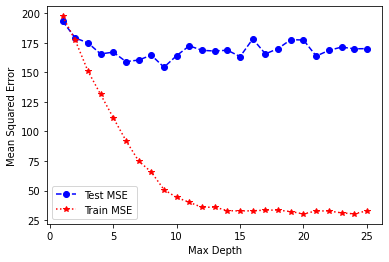

Top 5 Random Forest Features:
            Feature  Importance
1   actual_duration    0.281725
0        enrollment    0.205055
9   AE_serious_freq    0.134009
10    AE_other_freq    0.127061
8      mean_age_imp    0.049341


In [38]:
# Instantiate random forest regressor, fit and score with default parameters
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
print("Default Score:", rfr.score(x_test, y_test))

# Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
mse_train = []
mse_test = []

depths = range(1, 26)
for i in depths:
    rfr = RandomForestRegressor(max_depth=i)
    rfr.fit(x_train, y_train)
    y_pred_test = rfr.predict(x_test)
    y_pred_train = rfr.predict(x_train)
    mse_test.append(mean_squared_error(y_test, y_pred_test))
    mse_train.append(mean_squared_error(y_train, y_pred_train))

# Find the best accuracy and at what depth that occurs
print("Minimum Test MSE:", np.min(mse_test))
best_depth = depths[np.argmin(mse_test)]
print("Best Depth:", best_depth)

# Plot the MSE scores for the test and train set over the range of depth values
plt.plot(depths, mse_test, 'bo--', depths, mse_train, 'r*:')
plt.legend(['Test MSE', 'Train MSE'])
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

# Save the best random forest model and save the feature importances in a dataframe
best_rfr = RandomForestRegressor(max_depth=best_depth)
best_rfr.fit(x_train, y_train)
feature_imp_df = pd.DataFrame(zip(x_train.columns, best_rfr.feature_importances_), columns=['Feature', 'Importance'])
print('Top 5 Random Forest Features:')
print(feature_imp_df.sort_values('Importance', ascending=False).iloc[:5])

In [42]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 9],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] # The function to measure the quality of a split.
}


# Instantiate GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'criterion': 'poisson', 'max_depth': 3, 'min_samples_split': 10}
Mean Squared Error: 172.30719521677096
Mean Absolute Error: 7.2925139696720995
R-squared: 0.34598150826583884
